# RSNA Pneumonia Detection Challenge

### Importing required libraries
Let us import the libraries that are required in our project. 'pathlib' library  represents filesystem paths. 'pydicom' is required to work with dicom files. cv2, numpy, pandas, matplotlib are basic data science libraries. 'tqdm' will show progress bar. We use Pytorch Lightning in our project.

In [2]:
from pathlib import Path
import pydicom
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import IntProgress

# pytorch libraries for deep learning modelling
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

### Reading data
patientId _- A patientId. Each patientId corresponds to a unique image. <br/>
x_ - the upper-left x coordinate of the bounding box. <br/>
y_ - the upper-left y coordinate of the bounding box. <br/>
width_ - the width of the bounding box. <br/>
height_ - the height of the bounding box. <br/>
Target_ - the binary Target, indicating whether this sample has evidence of pneumonia. <br/>

In [3]:
# reading labels data
labels = pd.read_csv("input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Let's create a ROOT_PATH that takes a path to our train dataset.

Additionally, let's define a SAVE_PATH that defines path to the place where our processed images are saved.

In [4]:
# defining the root path to importing images and files and save path to save the models and images
ROOT_PATH = Path("input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("processed")

Now, we are going to observe some images. We generate a 3x3 grid of subplots, where each subplot displays a chest X-ray image from the training set along with its associated label. Where label 0 indicating no Pneumonia and 1 indicating there is some evidence of Pneuomia. Let us define the labels in our own way to create a proper visualization.

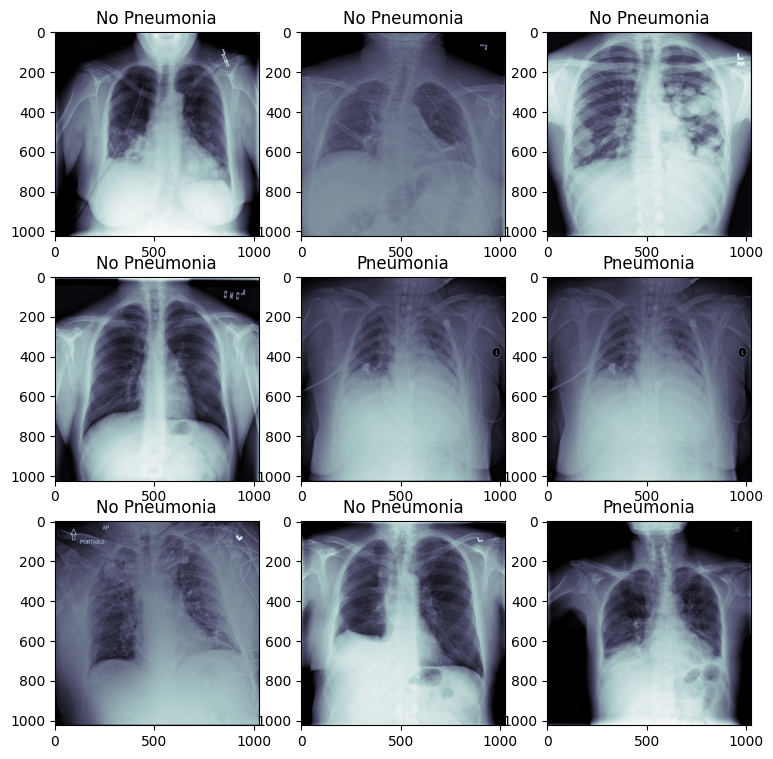

In [5]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
label_dict={0:'No Pneumonia',1:'Pneumonia'}
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = label_dict[labels['Target'].iloc[c]]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c += 1

### Preprocessing images
At first, we standardize each pixel by dividing by 255. <br/>
We resize all the images in the shape of 224x224 and convert them to float. <br/>
We identify all training and validation images. <br/>
Lastly, we calculate the mean and standard deviation.


In [6]:
sums, sums_squared = 0, 0

#iterate throught the patientID
for c, patient_id in enumerate(tqdm(labels.patientId)):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        
        #dividing each pixel by 255
        dcm = pydicom.read_file(dcm_path).pixel_array / 255
        
        #resize all images in the shape of 224 and convert them to float
        dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
        
        label = labels.Target.iloc[c]
        
        #identify traning or validation images
        train_or_val = 'train' if c < 24000 else 'val'
        
        #save preprocessed images
        current_save_path = SAVE_PATH/train_or_val/str(label)
        current_save_path.mkdir(parents=True, exist_ok=True)
        np.save(current_save_path/patient_id, dcm_array)
        
        #finding the mean and standard deviation
        normalizer = 224 * 224
        if train_or_val == "train":
            sums += np.sum(dcm_array) / normalizer
            sums_squared += (dcm_array ** 2).sum() / normalizer

mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)
mean, std

  0%|          | 0/30227 [00:00<?, ?it/s]

(0.4889087844122021, 0.24617960640014458)

Let us now load the data

In [7]:
def load_file(path):
    return np.load(path).astype(np.float32)

### Training and validation
We create two transforms for training and validation dataset. Transforms are required to increase the model's ability to generalize to new images and improve its overall performance. <br/>
train_transforms - normalizes the tensor and augments data by random affine transformations and random cropping <br/>
val_transforms - here I only normalize the data <br/>

After that we create the training and validation datapath.

In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.5), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [9]:
train_dataset = torchvision.datasets.DatasetFolder("processed/train/", loader=load_file, extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

Let us visualize some preprocessed images

C:\Users\Radit\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


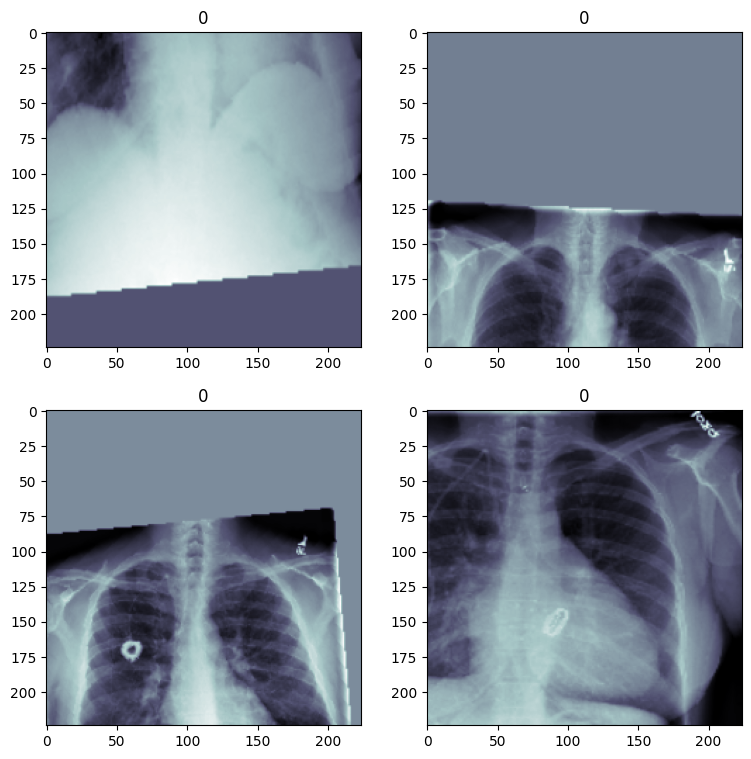

In [10]:
# Let's visualize 4 images from train dataset that are transformed 

fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

### Create DataLoader
I created two DataLoader classes train_loader and val_loader. <br/>
train_loader - loads the data in batches of size 64 and shuffles the order of the samples in each epoch. <br/>
val_loader - loads the validation data without shuffling. I used num_workers of 4 to parallelize the data loading process for faster performance.

In [11]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Now, I check if our dataset is imbalanced or not. If there is a large difference in the count of each label, it suggests that the dataset is imbalanced. Imbalanced data will cause poor performance.

In [12]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([16008,  4985], dtype=int64))

The data is imbalanced so we perform wighted loss. Let us now create the model architecture which is Resnet18.

### Model Architecture
I used ResNet18, which is a popular convolutional neural network architecture. The model is modified by changing the number of input channels to 1 (since the input images are grayscale) and by changing the output layer to a single neuron for binary classification. Here is the explanation of the following code structure.



In [13]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Val loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))


    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
                 
    def configure_optimizers(self):
        return [self.optimizer]
               

In [14]:
model = PneumoniaModel()

In [15]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val ACC",
    save_top_k=10,
    mode="max"
)

In [16]:
devices = 1
trainer = pl.Trainer(accelerator='cpu', devices=devices, logger=TensorBoardLogger(save_dir='./log'),
                    log_every_n_steps=1,
                    callbacks=checkpoint_callback, max_epochs=3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
from torch.multiprocessing import set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass


In [ ]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]